In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os


from fastai.vision import *
from fastai.metrics import error_rate
from fastai.vision import *
from torchvision.models import *
from glob import iglob
import cv2
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import os
from IPython.display import Image

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/classification/Car-Recognition/res34

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/classification/Car-Recognition/res34


In [0]:
data_dir='/content/drive/My Drive/classification/Car-Recognition/data'
train_dir = "/content/drive/My Drive/classification/Car-Recognition/data/train/*/*.jpg"
data_path = Path(data_dir)

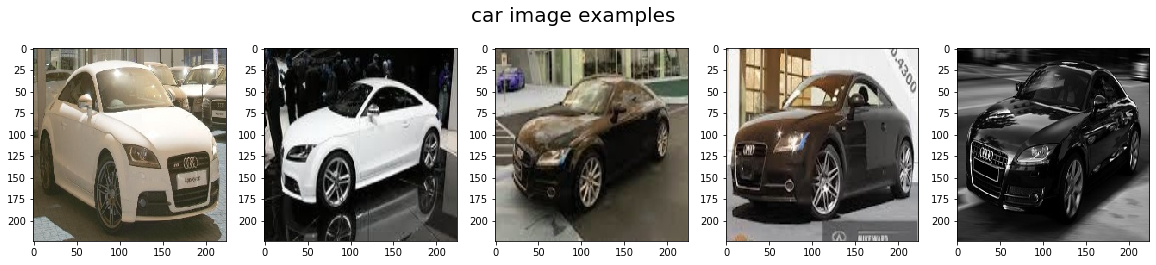

In [0]:
fig, ax = plt.subplots(1,5, figsize=(20,4))
fig.suptitle('car image examples',fontsize=20)
# choose some images to plot
cnt = 1
plt.figure(1)

for img_path in iglob(train_dir):
    img = cv2.imread(img_path)
    plt.subplot(1,5,cnt)
    plt.imshow(img)
    #ax[0,cnt].imshow(img)
    cnt += 1
    if cnt > 5:
        break

In [0]:
# Create ImageDataBunch using fastai data block API
batch_size = 64
data = ImageDataBunch.from_folder(data_path,  
                                  valid_pct=0.2,
                                  ds_tfms=get_transforms(do_flip=True,flip_vert=False, max_rotate=30, max_zoom=0.1, max_lighting=0.1),
                                  size=224,
                                  bs=batch_size, 
                                  num_workers=0).normalize([tensor([0.454952, 0.460148, 0.470733]), tensor([0.302969, 0.294664, 0.295581])])
                                  # Normalize with training set stats. These are means and std's of each three channel and we calculated these previously in the stats step.

In [0]:
def getLearner():
    return cnn_learner(data, resnet50, pretrained=True, path='.', metrics=accuracy, ps=0.5, callback_fns=ShowGraph)
learner = getLearner()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 89.3MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,4.585619,3.060035,0.270885,01:28
1,3.051815,2.163745,0.447789,01:28
2,2.194455,1.792207,0.535012,01:28
3,1.677912,1.560777,0.597666,01:28
4,1.435036,1.392628,0.623464,01:28
5,1.218668,1.312187,0.654177,01:28
6,1.041515,1.278434,0.638821,01:27
7,0.961449,1.229409,0.669533,01:28
8,0.862623,1.185434,0.683047,01:29
9,0.742627,1.153340,0.687961,01:29


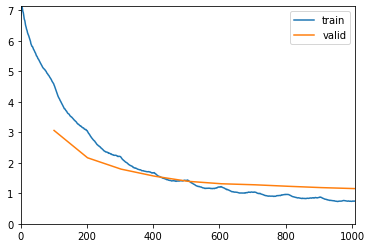

In [0]:
learner = getLearner()
learner.fit(epochs = 10)

In [0]:

lrs = []
losses = []
wds = [1e-6, 1e-5, 1e-4]
iter_count = 300

for wd in wds:
    learner = getLearner() #reset learner - this gets more consistent starting conditions
    learner.lr_find(wd=wd, num_it=iter_count)
    lrs.append(learner.recorder.lrs)
    losses.append(learner.recorder.losses)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


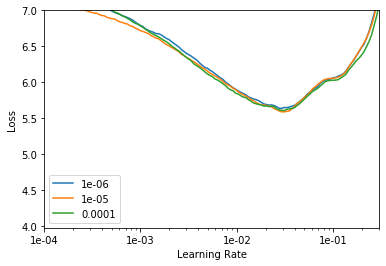

In [0]:
_, ax = plt.subplots(1,1)
min_y = 4
max_y = 7
for i in range(len(losses)):
    ax.plot(lrs[i], losses[i])
    min_y = min(np.asarray(losses[i]).min(), min_y)
ax.set_ylabel("Loss")
ax.set_xlabel("Learning Rate")
ax.set_xscale('log')

ax.set_xlim((1e-4,3e-1))
ax.set_ylim((min_y - 0.02,max_y))
ax.legend(wds)
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))

epoch,train_loss,valid_loss,accuracy,time
0,5.029083,3.221797,0.248157,09:59
1,3.487365,3.184063,0.289312,01:29
2,2.990381,3.230247,0.328624,01:29
3,2.232113,2.029422,0.503685,01:29
4,1.718731,1.568964,0.582924,01:29
5,1.340727,1.437438,0.616093,01:29
6,0.986010,0.912352,0.751843,01:29
7,0.686631,0.744216,0.797912,01:30
8,0.476338,0.629490,0.825553,01:29
9,0.387092,0.618274,0.826167,01:28


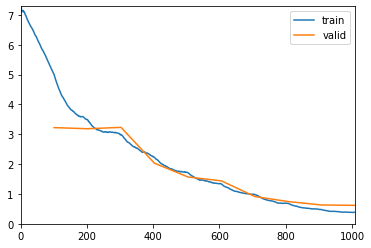

In [0]:
max_lr = 1e-2
wd = 1e-5
# 1cycle policy
learner_one_cycle = getLearner()
learner_one_cycle.fit_one_cycle(cyc_len=10, max_lr=max_lr, wd=wd)

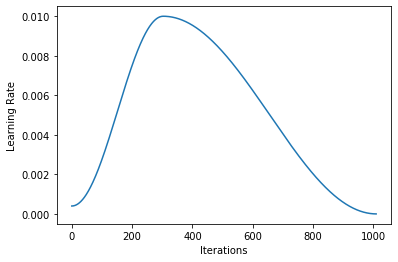

In [0]:
learner_one_cycle.recorder.plot_lr()


In [0]:
learner_one_cycle.save('Res50_stage1', return_path=True)


PosixPath('models/v4_stage1.pth')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


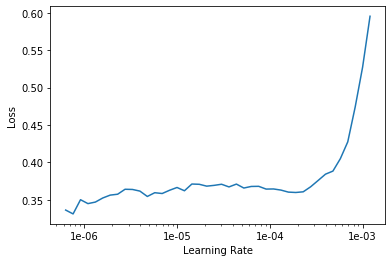

In [0]:
# unfreeze and run learning rate finder again
learner_one_cycle.unfreeze()
learner_one_cycle.lr_find(wd=wd)

# plot learning rate finder results
learner_one_cycle.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.369136,0.646406,0.812039,01:36
1,0.507085,0.982347,0.743858,01:37
2,0.605537,0.883973,0.743858,01:37
3,0.498553,0.728808,0.803440,01:36
4,0.386650,0.655459,0.815111,01:36
5,0.305205,0.577595,0.848894,01:36
6,0.229226,0.523354,0.861794,01:36
7,0.160997,0.481467,0.878993,01:36
8,0.124807,0.446393,0.885135,01:36
9,0.113937,0.449516,0.880835,01:36


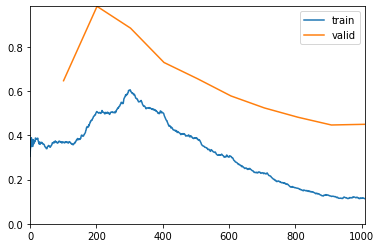

In [0]:
# Now, smaller learning rates. This time we define the min and max lr of the cycle
learner_one_cycle.fit_one_cycle(cyc_len=10, max_lr=slice(5e-5,5e-4))
# Save the finetuned model
learner_one_cycle.save('v4_stage2')

In [0]:
# most confused 
interp = ClassificationInterpretation.from_learner(learner_one_cycle)
interp.most_confused()


[('0009', '0008', 6),
 ('0013', '0022', 3),
 ('0014', '0019', 3),
 ('0016', '0017', 3),
 ('0056', '0055', 3),
 ('0071', '0064', 3),
 ('0083', '0084', 3),
 ('0104', '0103', 3),
 ('0177', '0176', 3),
 ('0005', '0002', 2),
 ('0005', '0003', 2),
 ('0008', '0010', 2),
 ('0010', '0008', 2),
 ('0012', '0021', 2),
 ('0014', '0025', 2),
 ('0018', '0017', 2),
 ('0019', '0025', 2),
 ('0022', '0013', 2),
 ('0054', '0074', 2),
 ('0059', '0107', 2),
 ('0064', '0071', 2),
 ('0074', '0054', 2),
 ('0088', '0166', 2),
 ('0089', '0159', 2),
 ('0103', '0102', 2),
 ('0120', '0062', 2),
 ('0122', '0074', 2),
 ('0144', '0036', 2),
 ('0170', '0099', 2),
 ('0179', '0180', 2),
 ('0181', '0184', 2),
 ('0001', '0124', 1),
 ('0002', '0003', 1),
 ('0003', '0007', 1),
 ('0007', '0133', 1),
 ('0009', '0011', 1),
 ('0009', '0056', 1),
 ('0009', '0153', 1),
 ('0009', '0180', 1),
 ('0011', '0046', 1),
 ('0011', '0101', 1),
 ('0012', '0068', 1),
 ('0013', '0014', 1),
 ('0014', '0021', 1),
 ('0017', '0018', 1),
 ('0018', 

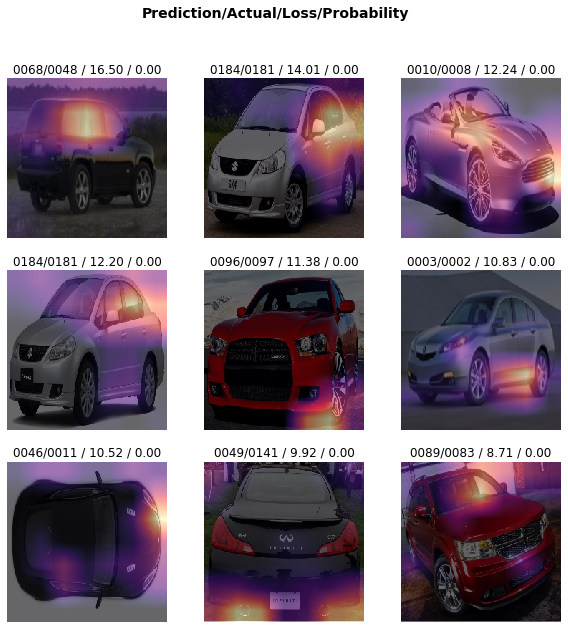

In [0]:
#some failue
interp.plot_top_losses(9, figsize=(10,10),heatmap=True)


In [0]:
# load model
#learn = load_learner(path)


In [0]:
#load label_name
from scipy.io import loadmat
annots = loadmat('/content/drive/My Drive/classification/Car-Recognition/devkit/cars_meta.mat')
annots = annots['class_names'][0]

In [0]:
test = ImageDataBunch.from_folder('/content/drive/My Drive/classification/Car-Recognition/data_2',
                                  size=224,
                                  train='test_2').normalize([tensor([0.454952, 0.460148, 0.470733]), tensor([0.302969, 0.294664, 0.295581])])

You can deactivate this warning by passing `no_check=True`.


/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:457: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")
/usr/local/lib/python3.6/dist-packages/fastai/basic_data.py:247: UserWarning: Your training dataloader is empty, you have only 1 items in your training set.
                 Your batch size is 64, you should lower it.
  Your batch size is {self.train_dl.batch_size}, you should lower it.""")


In [0]:
learner_one_cycle.predict(test.train_ds[0][0])

(Category 0163,
 tensor(162),
 tensor([1.1257e-08, 4.2971e-06, 4.6381e-07, 3.7893e-06, 4.7198e-06, 9.7358e-04,
         6.2743e-05, 1.6690e-05, 7.1110e-07, 1.8912e-06, 5.8813e-06, 1.8356e-04,
         3.0225e-07, 6.0320e-06, 1.2209e-06, 1.0093e-02, 9.7436e-05, 4.1999e-05,
         2.9173e-06, 1.5612e-06, 1.7313e-04, 1.1388e-06, 7.7364e-06, 3.1994e-06,
         1.1525e-06, 6.2865e-05, 2.9321e-04, 1.3092e-04, 3.5728e-05, 2.3906e-05,
         8.9926e-04, 1.2734e-06, 7.1451e-09, 2.0380e-05, 1.9471e-06, 1.3062e-03,
         1.0478e-06, 7.0311e-07, 9.8601e-04, 1.6413e-05, 1.8651e-06, 7.8230e-07,
         1.8214e-08, 5.1263e-07, 2.0229e-05, 1.0088e-06, 4.1117e-08, 4.9093e-06,
         1.5813e-08, 9.5853e-08, 1.4162e-05, 2.8778e-05, 3.2763e-07, 4.7487e-08,
         2.3269e-05, 7.8773e-04, 6.9479e-06, 3.8818e-09, 4.0246e-03, 6.4917e-08,
         5.5341e-08, 4.9664e-07, 1.1149e-06, 4.7384e-07, 1.2482e-07, 1.2295e-04,
         4.7741e-07, 2.1755e-08, 4.2496e-08, 2.0252e-06, 1.2907e-07, 3.5741e-08

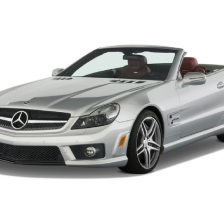

In [0]:
test.train_ds[0][0]

In [0]:
annots[163]

array(['Mercedes-Benz E-Class Sedan 2012'], dtype='<U32')